# Imports

In [265]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from functools import partial
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img, save_img
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.efficientnet_v2 import EfficientNetV2B0
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# For reproducibility
tf.keras.utils.set_random_seed(42)

In [206]:
import sys
sys.path.append("..")
 
from Helper import config

# Set Training and Validation Datasets

### Directories

For training, we will work with the Train and Validation directories, each of which contain child directories named "Real" and "Fake" from which Keras will infer class labels

In [155]:
train_directory = '../../Data/Train/'
validation_directory = '../../Data/Validation/'

### Image Shapes

Each image is 256 x 256 x 3 (the third number indicating that we are working with color images with channels: R, G and B)

In [85]:
img = img_to_array(load_img(train_directory + 'Fake/Fake_10.jpg'))

w = img.shape[0]
h = img.shape[1]

The ```image_dataset_from_directory()``` method from the keras API will use the given directories to infer which data belongs to the training set and which class each observation belongs to. This method also allows for setting batch sizes and a random seed to make results reproducible.

In [156]:
train_ds = image_dataset_from_directory(
    directory=train_directory,
    image_size=(w, h),
    batch_size=64,
    seed=42,
    label_mode='binary',
)

val_ds = image_dataset_from_directory(
    directory=validation_directory,
    image_size=(w, h),
    batch_size=64,
    seed=42,
    label_mode='binary',
)

Found 140002 files belonging to 2 classes.
Found 39428 files belonging to 2 classes.


# CNN Model

This Convolutional Neural Network is used as a benchmark against which I will compare the EfficientnetV2B0.
* It is the best of several relatively simple architechtures that were trained and evaluated
* Relatively quick to train (around 10 minutes per epoch with GPU acceleration on an M1 Macbook Pro)
* Slightly Fewer Parameters than EfficientnetV2B0 (~4M vs ~6M)
* Includes BatchNormalization and Dropout to mitigate against overfitting

### Build Model Architecture

In [260]:
# Reduced complexity and added normalization and dropout to an approach taken here, based on a theory that it would improve performance 
# https://www.kaggle.com/code/slimreaper/inceptionv3-88-classification

cnn_model = Sequential()

cnn_model.add(Rescaling(1./255, input_shape=(h,w,3)))

cnn_model.add(Conv2D(16, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Conv2D(32, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Conv2D(64, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Flatten())

cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.3))

cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.3))

cnn_model.add(Dense(1, activation='sigmoid'))

In [261]:
cnn_model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_28 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 conv2d_69 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_71 (Conv2D)          (None, 60, 60, 64)      

### Compile Model
* binary crossentropy as loss function
* Adam optimizer

In [262]:
cnn_model.compile(optimizer='adam',
                  loss='bce',
                  metrics=['acc']
                 )

### Fit Model and Save Performance History

In [263]:
cnn_history = cnn_model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10


2023-05-20 21:02:58.506103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2188/2188 [==============================] - ETA: 0s - loss: 0.3256 - acc: 0.8562

2023-05-20 21:13:09.844632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2188/2188 [==============================] - 680s 310ms/step - loss: 0.3256 - acc: 0.8562 - val_loss: 0.2696 - val_acc: 0.8877
Epoch 2/10
2188/2188 [==============================] - 670s 306ms/step - loss: 0.1784 - acc: 0.9298 - val_loss: 0.2557 - val_acc: 0.8955
Epoch 3/10
2188/2188 [==============================] - 677s 309ms/step - loss: 0.1373 - acc: 0.9455 - val_loss: 0.2097 - val_acc: 0.9108
Epoch 4/10
2188/2188 [==============================] - 673s 308ms/step - loss: 0.1163 - acc: 0.9546 - val_loss: 0.2708 - val_acc: 0.9051
Epoch 5/10
2188/2188 [==============================] - 676s 309ms/step - loss: 0.0998 - acc: 0.9609 - val_loss: 0.2024 - val_acc: 0.9235
Epoch 6/10
2188/2188 [==============================] - 668s 305ms/step - loss: 0.0854 - acc: 0.9663 - val_loss: 0.2503 - val_acc: 0.9216
Epoch 7/10
2188/2188 [==============================] - 669s 306ms/step - loss: 0.0749 - acc: 0.9706 - val_loss: 0.2923 - val_acc: 0.9141
Epoch 8/10
2188/2188 [=======================

### Plot Training and Validation Metrics

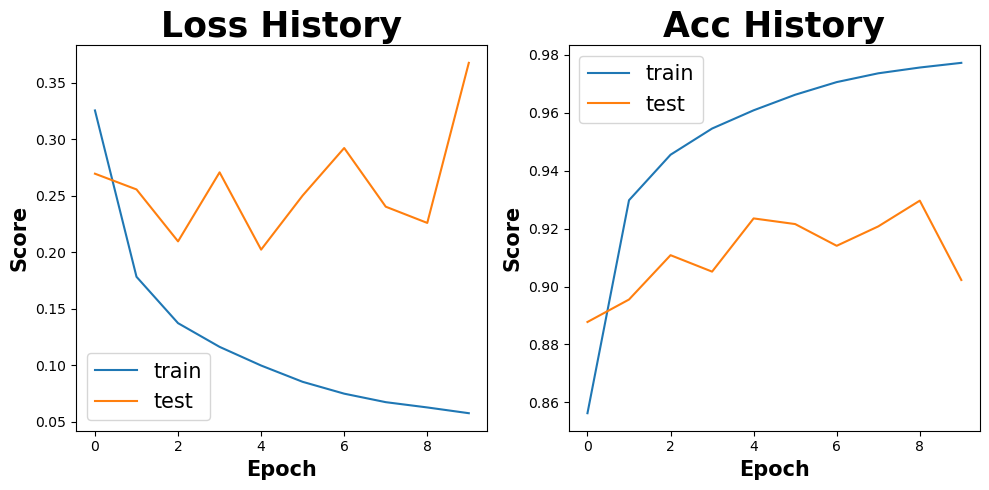

In [264]:
config.graph_me(cnn_history, ['acc'])

# EfficientnetV2B0 Model

### Head-Start Training
*This model is a slight adaptation of the EfficientnetV2B0 model (the smallest of the Efficientnet Version 2 models) that is available through the* ```tensorflow.keras.applications``` *module. In addition to more traditional appropaches to transfer learning using som of the larger models from the EfficientnetV2 family ([see this notebook](https://github.com/annabchox/deepfake-detector/blob/main/Code/Main/Training/Anna_NN.ipynb)), we decided to experiment with retraining all of the weignts of a smaller version of the model. To keep overall training time reasonable on a personal computer, we initialized the model weights with the 'imagenet' weights provided by the keras API to give the model a head-start in training. By setting the learning rate low and setting all layers as trainable, we were able to finely tune the model weights and achieve suprisingly good performance with only 10 epochs of training. An overview of our settings is listed below.*

**Weights:** Rather than training the model from scratch the initial weights were set using the pretrained weights trained on the imagenet dataset

**Output Layer:** Because the imagenet classification dataset contains 1000 image classes, it was necessary to set ```include_top_layer``` to False and replace the output layer of the model with a Dense layer with a single neuron and a sigmoid activation function.

**Learning Rate:** Because the model has already been trained to extract features from images for classification, albeit for different classification task, the learning rate was set very low (1e-6) to fine tune the weights for the deepfake classification problem at hand.

**Preprocessing:** ```include_preprocessing``` was set to true in order to ensure that the Efficientnet model received images in the expected format, with the expected scaling.

### Build Model Architecture

In [47]:
model = Sequential()

effnet_V2L = EfficientNetV2B0(
    weights='imagenet',   
    input_shape=(h,w,3), 
    include_top=False,
    pooling='max',
    classes = 2,
    include_preprocessing=True     #Efficientnet_2L expects [-1, 1] range, if set to False
)

effnet_V2L.trainable = True

model.add(effnet_V2L)

model.add(Dense(1, activation='sigmoid'))

24289280/24274472 [==============================] - 1s 0us/step


In [48]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 1280)             5919312   
 al)                                                             
                                                                 
 dense_2 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 5,920,593
Trainable params: 5,859,985
Non-trainable params: 60,608
_________________________________________________________________


### Compile the Model
* low learning rate (1e-6)
* Adam optimizer 

In [49]:
model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='bce',
    metrics=['acc']
)

### Fit Model and Log Performance

In [50]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10


2023-05-18 17:28:48.608097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2188/2188 [==============================] - ETA: 0s - loss: 0.3019 - acc: 0.8872

2023-05-18 18:28:05.681589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2188/2188 [==============================] - 3784s 2s/step - loss: 0.3019 - acc: 0.8872 - val_loss: 0.2602 - val_acc: 0.9033
Epoch 2/10
2188/2188 [==============================] - 3909s 2s/step - loss: 0.1009 - acc: 0.9617 - val_loss: 0.1820 - val_acc: 0.9311
Epoch 3/10
2188/2188 [==============================] - 3566s 2s/step - loss: 0.0610 - acc: 0.9765 - val_loss: 0.1432 - val_acc: 0.9465
Epoch 4/10
2188/2188 [==============================] - 3557s 2s/step - loss: 0.0392 - acc: 0.9851 - val_loss: 0.1265 - val_acc: 0.9544
Epoch 5/10
2188/2188 [==============================] - 3501s 2s/step - loss: 0.0252 - acc: 0.9910 - val_loss: 0.1173 - val_acc: 0.9590
Epoch 6/10
2188/2188 [==============================] - 3449s 2s/step - loss: 0.0170 - acc: 0.9944 - val_loss: 0.1168 - val_acc: 0.9614
Epoch 7/10
2188/2188 [==============================] - 3435s 2s/step - loss: 0.0120 - acc: 0.9961 - val_loss: 0.1092 - val_acc: 0.9649
Epoch 8/10
2188/2188 [==============================] - 358

### Plot Training and Validation Metrics

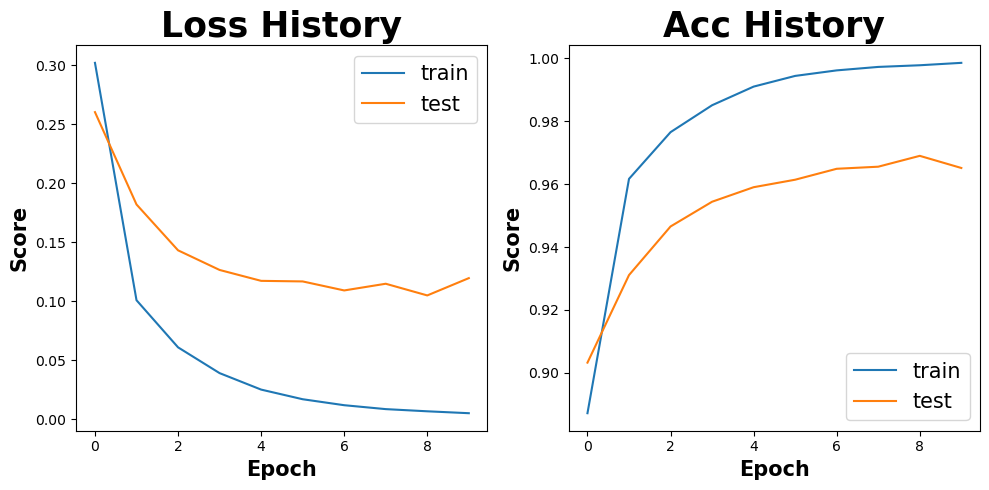

In [256]:
config.graph_me(history, ['acc'])

In [118]:
pd.DataFrame(history.history)

,loss,acc,val_loss,val_acc
0,0.301923,0.887195,0.260186,0.903267
1,0.100890,0.961665,0.181979,0.931090
2,0.060991,0.976507,0.143158,0.946535
3,0.039153,0.985065,0.126527,0.954398
4,0.025202,0.990986,0.117300,0.959014
5,0.017042,0.994386,0.116809,0.961398
6,0.011981,0.996143,0.109179,0.964873
7,0.008667,0.997243,0.114847,0.965532
8,0.006824,0.997772,0.104951,0.968981
9,0.005208,0.998536,0.119601,0.965126


***After 10 epochs of training, there is still some evidence of overfitting in both the loss and accuracy curves, but it is less pronounced than in the CNN model. The overall validation accuracy of 0.9651 is also significantly higher than the validation accuracy of the CNN model.***

# Results

**Overfitting:** Despite the much greater complexity of the Efficientnet architecture, the efficienet suffers from much less pronounces overfitting

**Accuracy:** Perhaps most importantly, the Efficientnet model acheived a much higher level of accuracy after 10 epochs. *Granted this is not exactly a one-to-one comparison, given that the EfficientnetV2B0 started with pretrained weights from another image classification problem.*

**Training Time:** The Efficientnet model took around 4 times longer to train per epoch, which is unsurprising given the increased complexity of the model.

**Overall:** The EfficientnetV2B0 is the clear choice between these two models. Despite the longer training time, it was still able to complete 10 epochs within a single evening training on an M1 Macbook Pro with GPU acceleration. This is a reasonable amount of computing resources required for even the most buget conscious of users on a tight time-constraint. The massive increase in accuracy while also reducing overfitting is worth the extra hours of training, as similar results would like take much longer if achieved by iterating on more complex versions of a basic CNN Model.

# The Value of Transfer Learning

The open-source availability of complex, well-researched deep learning models and their respective pretrained weights presents budget and time-conscious users with opportunities to develop tools with state-of-the-art performance. Models like the EfficientnetV2 series represent another step forward in the open-sourcing of models, introducing models small enough to be retrained on a personal computer (like the B0 trained above), while still delivering a very high standard of performance.

We have saved both the architecture and the pretrained weights of our efficientnetv2-b0 model adapted for binary classification of authentic and deepfake images, and these are available for download in the repository where this notebook is located. We have also provided a tutorial notebook that gives a detailed walk-through of how to load the model with the pretrained weights, how to use our model for out-of-the-box inference, and how to use transfer learning with our pretrained model to adapt this model to other deepfake classification datasets or other similar classification tasks. All of these resources can be found [here]()